# Train a classification model for Sentinel-1

## Load packages

In [1]:
%matplotlib inline

import os
os.environ['USE_PYGEOS'] = '0'
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import itertools
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from deafrica_tools.classification import predict_xr
import random
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

## Load training datasets

In [2]:
input_folder='data'
files=glob.glob(os.path.join(input_folder,'*.npz'))
location_names=[]
list_data=[]
list_labels=[]
for file in files:
    location_names.append(os.path.basename(file).split('.')[0])
    dataset = np.load(file)
    data=dataset['data']
    labels=dataset['labels']
    
    # subsample
    if data.shape[0]>10000:
        rand_indices=random.sample(range(0, data.shape[0]), 10000)
        data=data[rand_indices]
        labels=labels[rand_indices]
    
    list_data.append(data)
    list_labels.append(labels)

data=np.concatenate(list_data)
labels=np.concatenate(list_labels)
print('locations: ',location_names)

locations:  ['Madagarscar_south', 'Madagarscar_west', 'Tanzania', 'Kenya', 'Comoros']


#### Load feature names for plot

In [3]:
with open ('s1_features', 'rb') as file:
    feature_names = pickle.load(file)
print(feature_names)

['vh', 'vv', 'vv_a_vh', 'vv_m_vh', 'area', 'vh_std', 'vv_std', 'vv_a_vh_std', 'vv_m_vh_std', 'area_std']


## Build a classifier

### Fit a random forest model per location

In [4]:
models=[]
for i in range(len(location_names)):
    rf=RandomForestClassifier(n_estimators=200,max_samples=0.5,min_samples_leaf=1,bootstrap=True)
    rf.fit(list_data[i],list_labels[i])
    models.append(rf)

### Plot feature importance

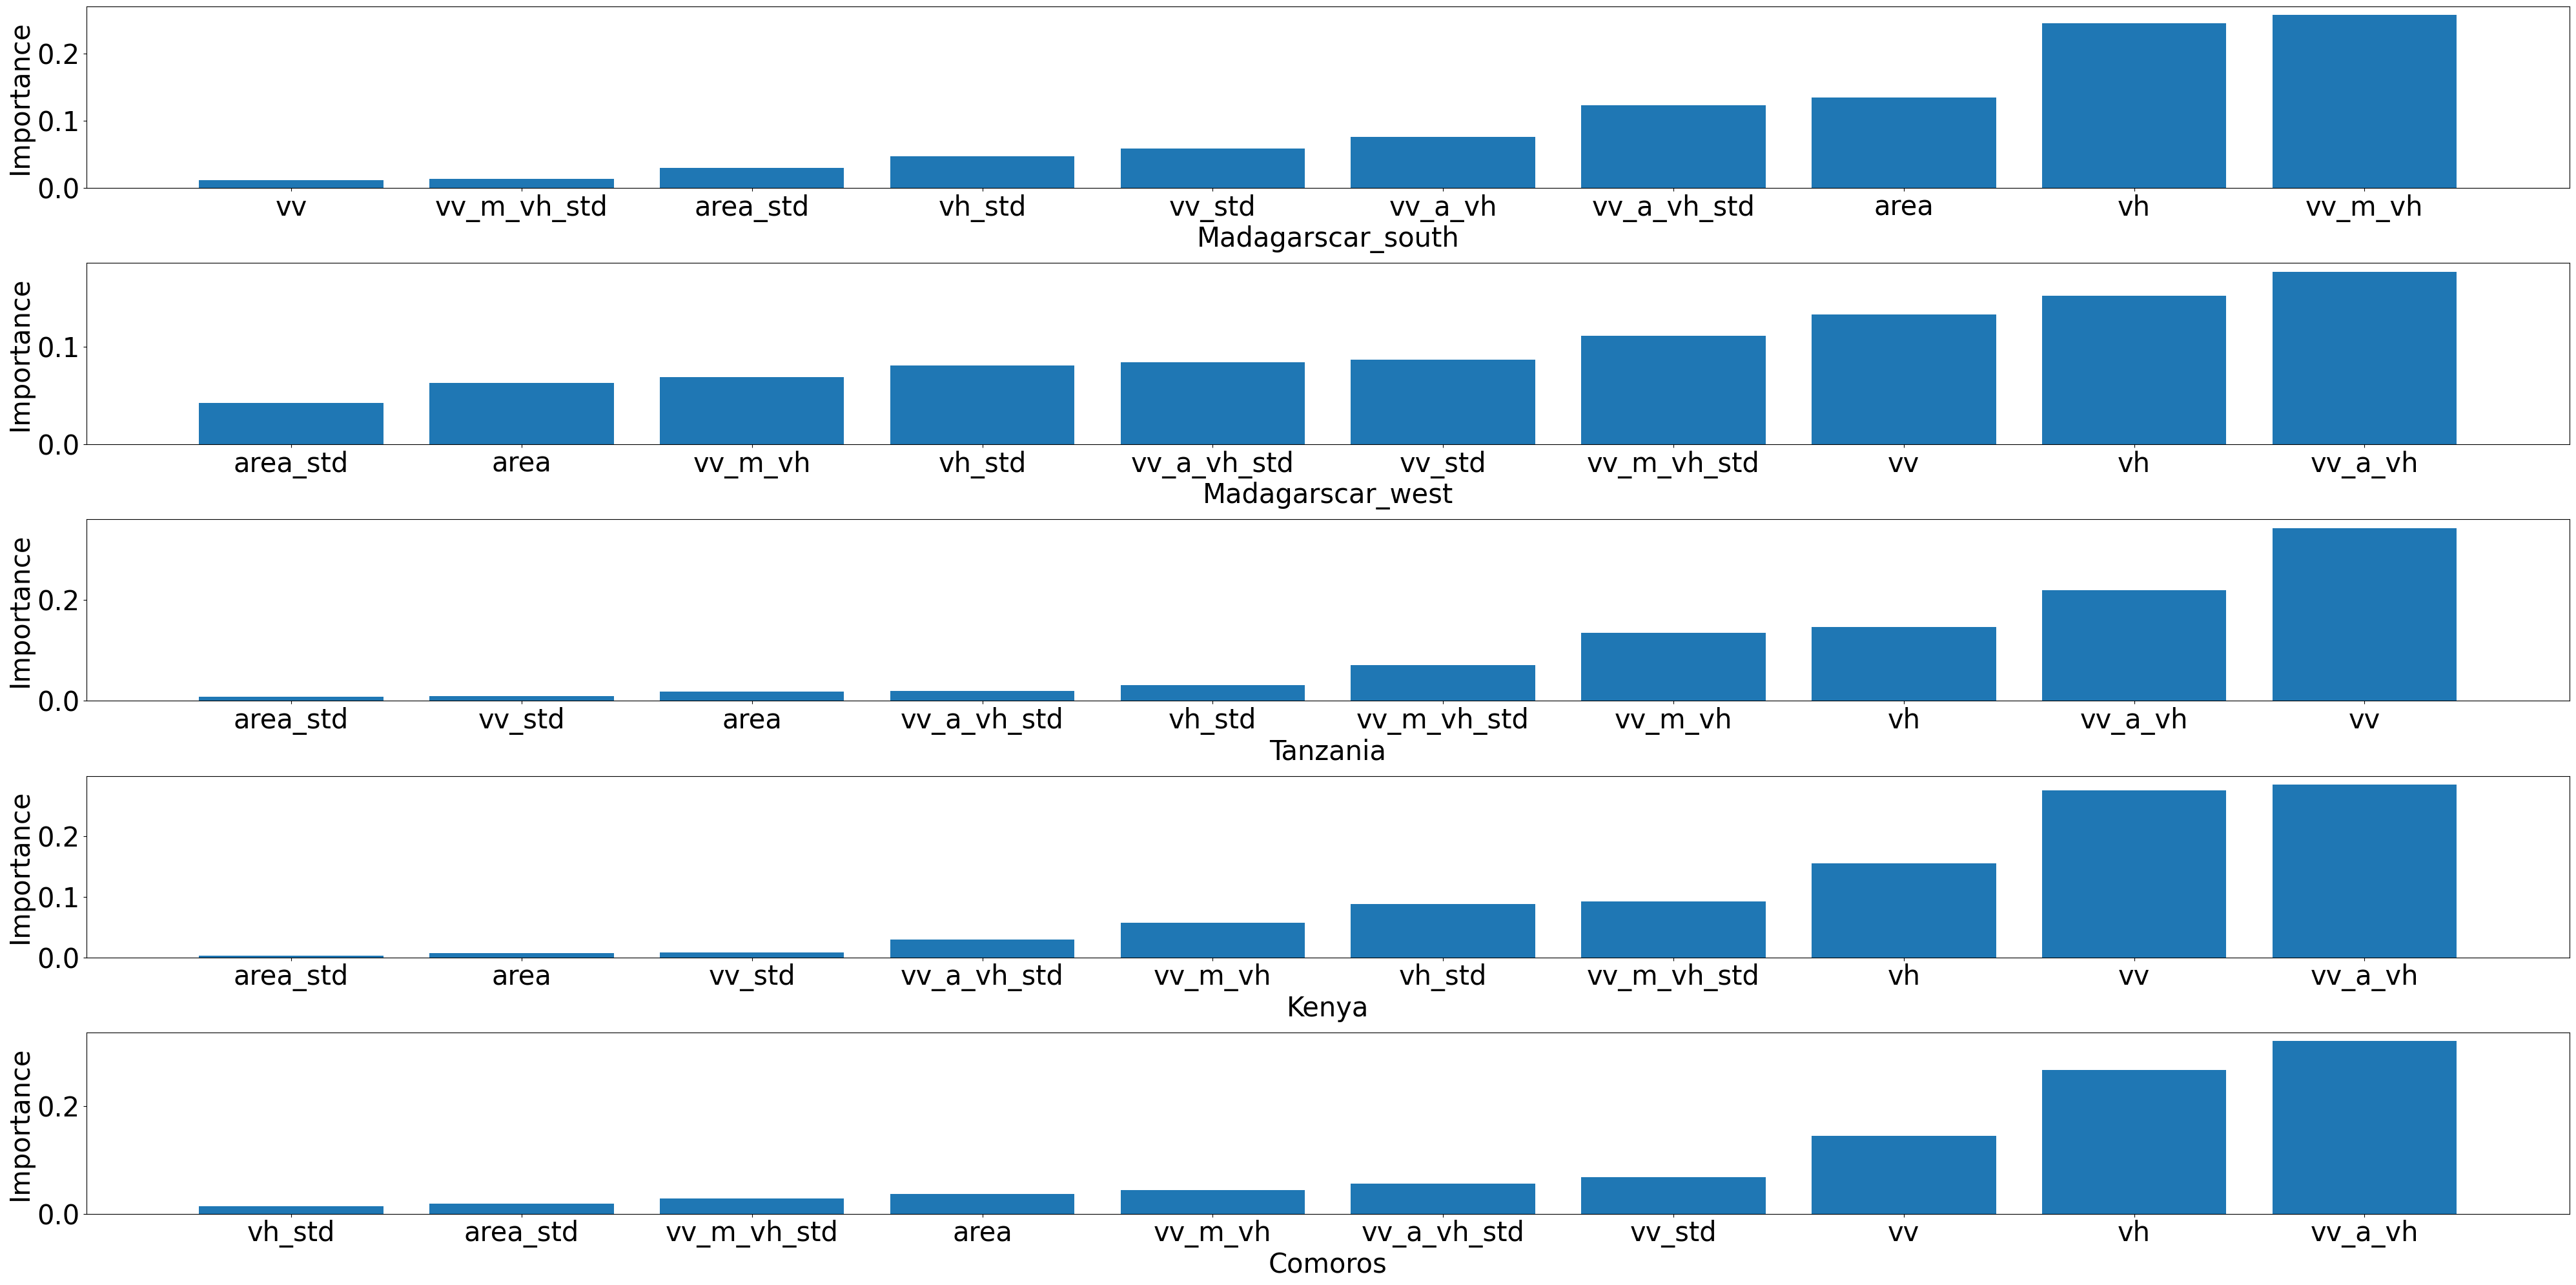

In [7]:
fig, ax=plt.subplots(len(location_names),1,figsize=(40,20))
for i in range(len(location_names)):
    order=np.argsort(models[i].feature_importances_)
    ax[i].bar(x=np.array(feature_names)[order],height=models[i].feature_importances_[order])
    ax[i].set_ylabel('Importance',fontsize=30)
    ax[i].set_xlabel(location_names[i],fontsize=30)
    ax[i].tick_params(axis='x', labelsize=30)
    ax[i].tick_params(axis='y', labelsize=30)
    # Save the models
    outfile='rf_model_'+location_names[i]
    with open(outfile,'wb') as out_model:
        pickle.dump(models[i],out_model)
plt.tight_layout()
plt.show()

### Plot confusion matrix by location

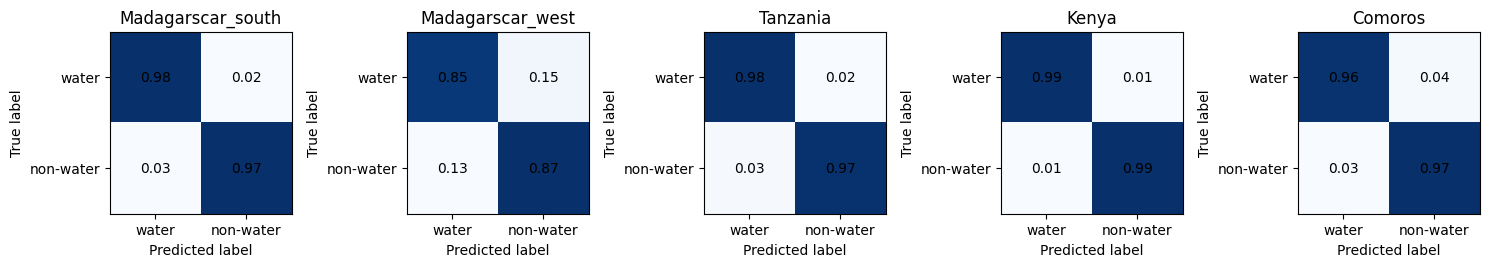

In [6]:
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1) # stratified K-fold splitting
fig, ax = plt.subplots(1,len(location_names),figsize=(15,3))
for i in range(len(location_names)):
    predictions_i=model_selection.cross_val_predict(models[i],list_data[i],list_labels[i],cv=skf)
    cm=confusion_matrix(list_labels[i], predictions_i)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax[i].imshow(cm, cmap='Blues')
    for row in range(len(cm)):
        for col in range(len(cm)):
            value = "{:.2f}".format(cm[row, col])
            ax[i].text(col, row, value, ha='center', va='center', color='black')
    ax[i].set_title(location_names[i])
    ax[i].set_xlabel('Predicted label')
    ax[i].set_ylabel('True label')
    tick_labels = ['water','non-water']
    ax[i].set_xticks(np.arange(len(tick_labels)))
    ax[i].set_yticks(np.arange(len(tick_labels)))
    ax[i].set_xticklabels(tick_labels)
    ax[i].set_yticklabels(tick_labels)
plt.tight_layout()
plt.show()